# The Driven Harmonic Oscillator

In this notebook, we will go through implementing the driven harmonic system for which we'll train a neural network to learn to control the oscillator state.

We will train a separate network to learn the system dynamics as well. 

A part of this exercise will also show you how to make animations in matplotlib!

In [1]:
# We restrict the number of PyTorch CPU threads to 1 as cpu training is
# slower with multiple threads due to the small sizes of network we're dealing with
%env OMP_NUM_THREADS = 1
%env OPENBLAS_NUM_THREADS = 1
%env MKL_NUM_THREADS = 1
%env VECLIB_MAXIMUM_THREADS = 1
%env NUMEXPR_NUM_THREADS = 1

env: OMP_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1
env: MKL_NUM_THREADS=1
env: VECLIB_MAXIMUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1


In [2]:
import warnings
import torch
import random
import numpy as np
import neuralode
import copy

warnings.simplefilter('ignore', RuntimeWarning)

In [3]:
# Again restrict the number of pytorch threads
torch.set_num_threads(1)
# For convenience, we define the default tensor device and dtype here
torch.set_default_device('cpu')
# In neural networks, we prefer 32-bit/16-bit floats, but for precise integration, 64-bit is preferred. We will revisit this later when we need to mix integration with neural network training
torch.set_default_dtype(torch.float64)
# Set the random seeds so that each run of this notebook is reproducible
torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

In [4]:
initial_position = torch.tensor(1.0)
initial_velocity = torch.tensor(0.0)

frequency = (torch.ones_like(initial_position))
damping = (torch.ones_like(initial_position)*0.25)
initial_state = torch.stack([
    initial_position,
    initial_velocity,
], dim=-1).requires_grad_(True)

initial_time = torch.tensor(0.0)
final_time   = torch.tensor(25.0)

initial_timestep = (final_time - initial_time) / 100

current_integrator = neuralode.integrators.AdaptiveRKV87Integrator

atol = rtol = torch.tensor(torch.finfo(initial_state.dtype).eps**0.5)

In [5]:
final_state, _, sha_states, sha_times, _ = current_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, initial_state, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, frequency, damping)

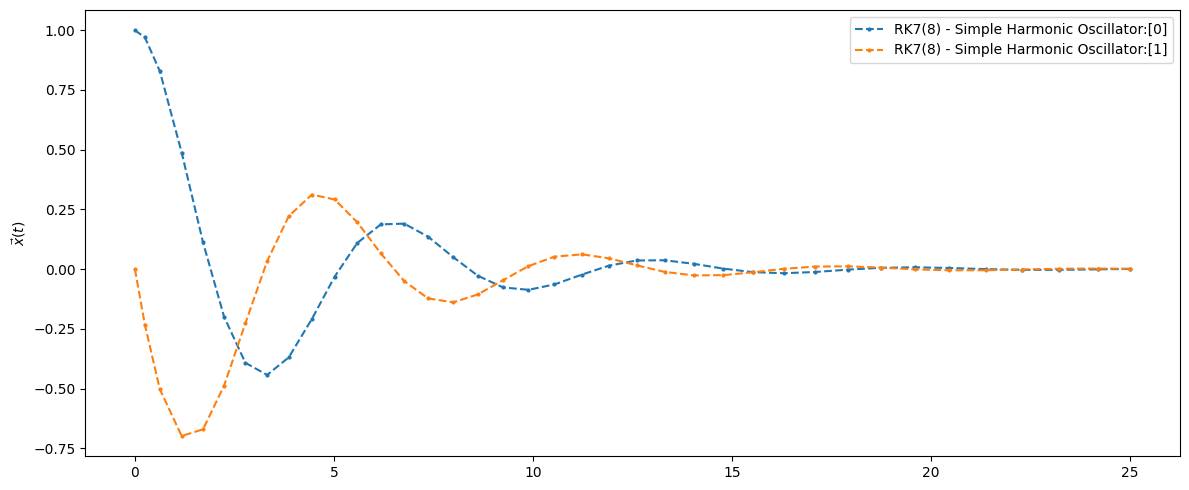

In [6]:
fig, axes = neuralode.plot.trajectory.plot_trajectory([(i, j) for i, j in zip(sha_states, sha_times)], method_label="RK7(8) - Simple Harmonic Oscillator")

## Learning to Fix the Oscillator State

Previously we learned the dynamics of this oscillator directly, here we will incorporate control of the oscillator. We'll be using the forced harmonic oscillator model where we not only have movement of the oscillator with the dynamics that come from the simple harmonic oscillator but also a driving force that does work on the system.

Mathematically, this is equivalent to  

$$
\begin{bmatrix}
    x^{(1)} \\
    v^{(1)}
\end{bmatrix} = 
\mathbf{A}
\begin{bmatrix}
    x \\
    v
\end{bmatrix} + 
\begin{bmatrix}
    0 \\
    F
\end{bmatrix}
$$

where

$$
\mathbf{A} =
\begin{bmatrix}
    0 & 1 \\
    -\omega^2 & -2\zeta\omega
\end{bmatrix}
$$

If we were to learn both the dynamics and the driving force together, we'd need both driven and undriven oscillator states as the two networks could learn some kind of combined dynamics that integrates the driving force into the RHS. In that fashion, we'd no longer be able to distinguish the dynamics of the oscillator itself from the driving force.

### Dataset and Loss Function Configuration

We create a dataset of 8 initial states which cover a range of positions and velocities, and use a loss function that penalises both the deviation from the target state at the end of the integration, but also cumulatively over the whole trajectory. 

In [7]:
state_range_min = torch.tensor([-25.0, -5.0])
state_range_max = torch.tensor([ 25.0,  5.0])

state_dataset = torch.rand(8, 2) * (state_range_max - state_range_min)[None] + state_range_min[None]

target_state = torch.tensor([1.0, 0.0])

def damping_closure(rhs, parameters, minibatch, optimiser, integrator_kwargs, integrator=None):
    
    if integrator is None:
        integrator = neuralode.integrators.AdaptiveRK45Integrator
    optimiser.zero_grad()
    
    t_final = minibatch['final_time']
    t_initial = minibatch['initial_time']
    initial_dt = minibatch['dt']
    states = minibatch['states']
    
    def damping_loss(state, time):
        # Measure of the unnormalised cosine alignement between the target state and the current state
        # When the current state is exactly the same as the target state, then the error is 0.0
        # When the current state is the opposite of the target state (i.e. -target_state), the error
        # is at its highest at 2|state|x|target| where |.| denotes the vector 2-norm
        deviation_from_target = torch.linalg.vector_norm(state.detach(), dim=-1, keepdim=True)*torch.linalg.norm(target_state, dim=-1, keepdim=True) - torch.linalg.vecdot(state, target_state, dim=-1)[...,None]
        return deviation_from_target
    
    def damping_augmented_rhs(state, time, *nn_parameters):
        return torch.cat([
            rhs(state[...,:-1], time, *nn_parameters),
            damping_loss(state[...,-1:], time)
        ], dim=-1)
    
    augmented_states = torch.cat([
        states,
        torch.zeros_like(states[...,0,None])
    ], dim=-1)

    final_augmented_state, _, _, _, _ = integrator.apply(damping_augmented_rhs, augmented_states, t_initial, t_final, initial_dt, integrator_kwargs, *parameters)

    error = (target_state - final_augmented_state[...,:-1]).square().sum(dim=-1).mean() + final_augmented_state[...,-1:].sum(dim=-1).mean()

    if error.requires_grad:
        error.backward()
    return error

### Network Specification

The network is a simple feed-forward network composed of dense layers and non-linearities, outputting a single control value, the acceleration of the oscillator.

In [8]:
driven_oscillator_net = neuralode.models.oscillator.DrivenOscillatorNet()
driven_oscillator_net.apply(neuralode.models.util.init_weights)
max_acceleration = torch.tensor(25.0)

def get_control(x, t, controller, *nn_parameters):
    x_encoded = torch.stack([x[...,0]/100.0, x[...,1]/100.0], dim=-1)
    control_u = torch.func.functional_call(controller, {k: p for (k, _), p in zip(controller.named_parameters(), nn_parameters)}, (x_encoded, t))
    control_u = control_u*max_acceleration
    return torch.cat([
        torch.zeros_like(control_u),
        control_u, # The network can only apply forces, not directly control the velocity of the oscillator
    ], dim=-1)

def dha_nn_fn(x, t, frequency, damping, *nn_parameters):
    # We rescale the input to the [-1, 1] range for better stability of the network
    control_vec = get_control(x, t, driven_oscillator_net, *nn_parameters)
    return neuralode.dynamics.simple_harmonic_oscillator(x, t, frequency, damping) + control_vec

### Training Configuration

We train for 128 with a batch size of 4 using the Adam optimiser and OneCycleLR learning rate schedule for accelerated convergence.

In [9]:
batch_size = 4
number_of_epochs = 64

driven_oscillator_optimiser = torch.optim.Adam(driven_oscillator_net.parameters(), lr=1e-4, amsgrad=True)
one_cycle_lr_driven_oscillator = torch.optim.lr_scheduler.OneCycleLR(driven_oscillator_optimiser, max_lr=2e-2, div_factor=200.0, steps_per_epoch=round(state_dataset.shape[0]/batch_size+0.5), epochs=number_of_epochs, three_phase=False)

### Training the Network

In [10]:
driven_oscillator_net.train()

best_error = torch.inf
best_parameters = copy.deepcopy(driven_oscillator_net.state_dict())

common_closure_args = [driven_oscillator_optimiser, {'atol': atol, 'rtol': rtol}, current_integrator]

for step in range(number_of_epochs):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(state_dataset.shape[0])
    for batch_idx in range(0, state_dataset.shape[0], batch_size):
        batch_dict = {
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
            'initial_time': initial_time.detach().clone(),
            'final_time': initial_time.detach().clone() + 2.5,
            'dt': initial_timestep.detach().clone()
        }

        step_error = driven_oscillator_optimiser.step(lambda: damping_closure(dha_nn_fn, [frequency, torch.zeros_like(damping)] + list(driven_oscillator_net.parameters()), batch_dict, *common_closure_args))
        one_cycle_lr_driven_oscillator.step()
        epoch_error = epoch_error + step_error.item()*batch_dict['states'].shape[0]
        print(f"[{step+1}/{number_of_epochs} - lr: {one_cycle_lr_driven_oscillator.get_last_lr()[0]:.4e}]/[{batch_idx}/{state_dataset.shape[0]}] Batch Error: {step_error:.4f} ", end='\r', flush=True)
    epoch_error = epoch_error/state_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_parameters = copy.deepcopy(driven_oscillator_net.state_dict())
    print(" "*128, end='\r', flush=True)
    print(f"[{step+1}/{number_of_epochs} - lr: {one_cycle_lr_driven_oscillator.get_last_lr()[0]:.4e}] Epoch Error: {epoch_error:.6}")
    print()

[1/64 - lr: 2.4008e-04] Epoch Error: 151.945                                                                                    

[2/64 - lr: 6.5639e-04] Epoch Error: 151.252                                                                                    

[3/64 - lr: 1.3372e-03] Epoch Error: 149.567                                                                                    

[4/64 - lr: 2.2633e-03] Epoch Error: 146.498                                                                                    

[5/64 - lr: 3.4087e-03] Epoch Error: 139.44                                                                                     

[6/64 - lr: 4.7411e-03] Epoch Error: 140.579                                                                                    

[7/64 - lr: 6.2230e-03] Epoch Error: 128.389                                                                                    

[8/64 - lr: 7.8126e-03] Epoch Error: 117.897                                              

### Testing the Network on Unseen Systems

In order to test this controller, let's generate several cases that the network hasn't seen and integrate the system. Ideally, we should observe rapid damping of oscillations, akin to critical damping.

In [11]:
test_range_min = torch.tensor([-256, -32.0])
test_range_max = torch.tensor([ 256,  32.0])

test_state_dataset = torch.rand(64, 2) * (test_range_max - test_range_min)[None] + test_range_min[None]

C:\Users\ekin4\PycharmProjects\ReCoDE-NeuralODEs\neuralode\plot\trajectory.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
C:\Users\ekin4\PycharmProjects\ReCoDE-NeuralODEs\neuralode\plot\trajectory.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


Training results on test data:
	Mean position at t=50.00s: 9.3575e-01 ± 3.4454e-11
	Mean position error at t=50.00s: 6.4254e-02 ± 3.4454e-11

	Mean velocity at t=50.00s: -2.4343e-11 ± 2.2306e-10
	Mean velocity error at t=50.00s: 2.4343e-11 ± 2.2306e-10


(-1.0, 1.0)

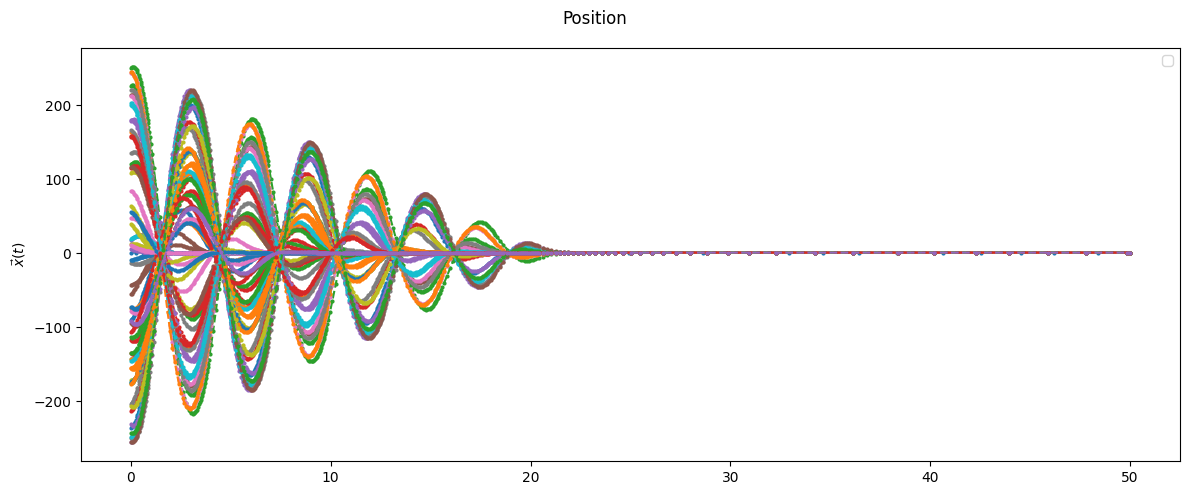

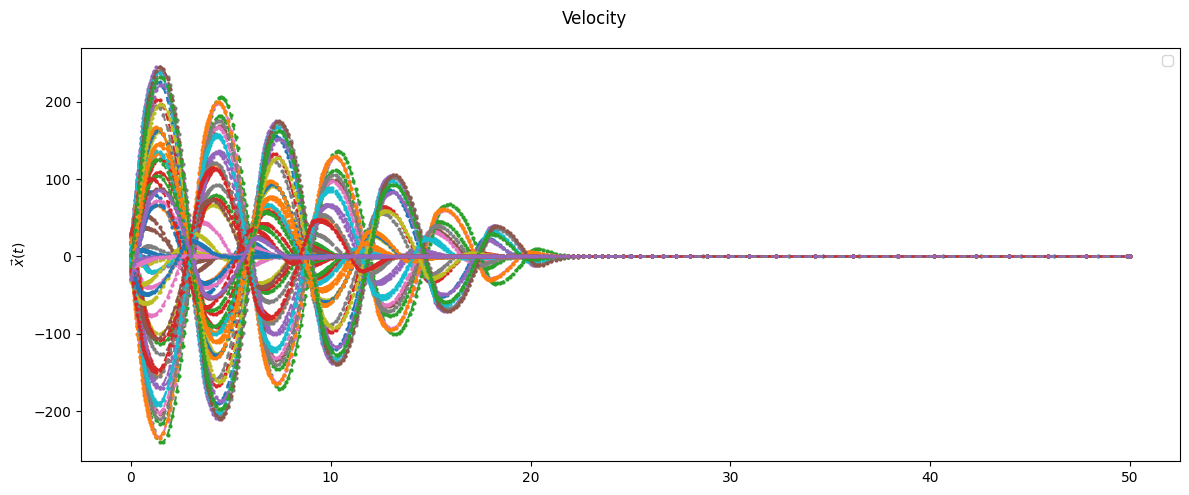

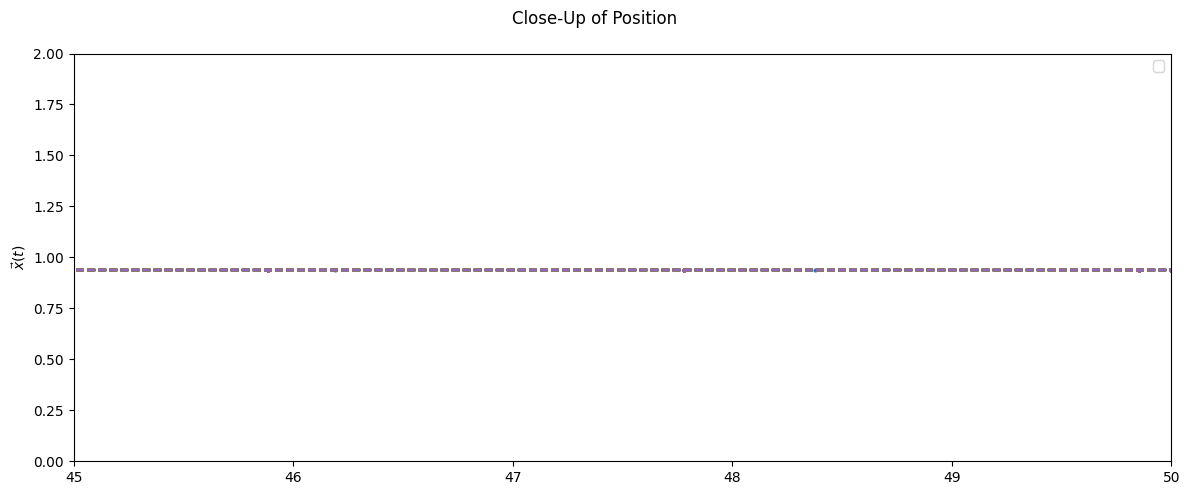

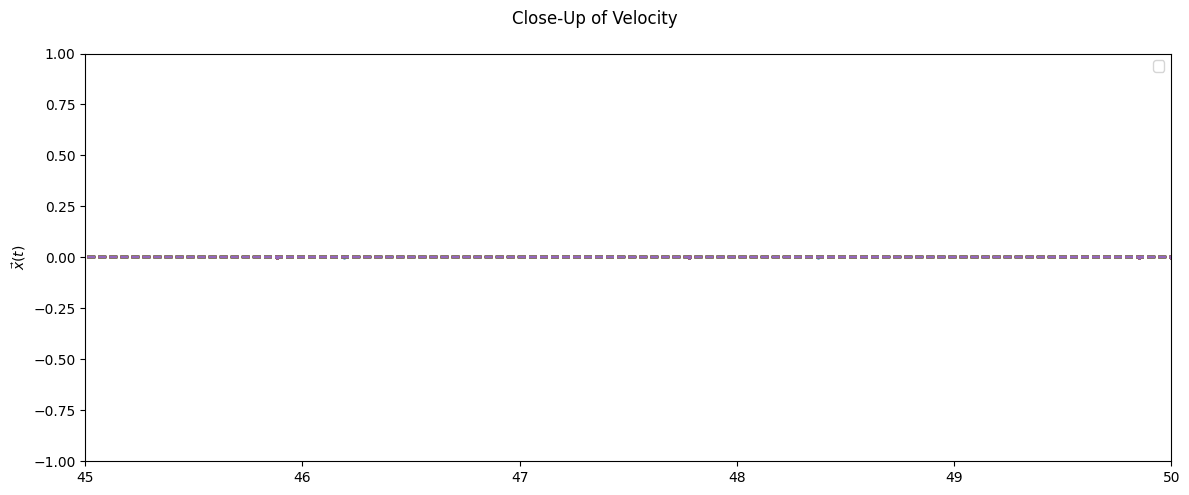

In [12]:
driven_oscillator_net.load_state_dict(best_parameters)
driven_oscillator_net.eval()

test_final_time = final_time*2.0

_, _, dha_states_optimised, dha_times_optimised, _ = current_integrator.apply(dha_nn_fn, initial_state, initial_time, test_final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, frequency, torch.zeros_like(damping))

fig_ref_position, axes_ref_position = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(dha_states_optimised, dha_times_optimised)], method_label=None)
fig_ref_position.suptitle("Position")
fig_ref_velocity, axes_ref_velocity = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(dha_states_optimised, dha_times_optimised)], method_label=None)
fig_ref_velocity.suptitle("Velocity")

_, _, integrated_test_states, integrated_test_times, _ = current_integrator.apply(dha_nn_fn, test_state_dataset, initial_time, test_final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, frequency, torch.zeros_like(damping))

_ = neuralode.plot.trajectory.plot_trajectory([(i[...,0], j) for i, j in zip(integrated_test_states, integrated_test_times)], axes=axes_ref_position, method_label=None)
_ = neuralode.plot.trajectory.plot_trajectory([(i[...,1], j) for i, j in zip(integrated_test_states, integrated_test_times)], axes=axes_ref_velocity, method_label=None)

print("Training results on test data:")
print(f"\tMean position at t={test_final_time.item():.2f}s: {integrated_test_states[-1, ..., 0].mean().item():.4e} ± {integrated_test_states[-1, ..., 0].std().item():.4e}")
print(f"\tMean position error at t={test_final_time.item():.2f}s: {(target_state - integrated_test_states)[-1, ..., 0].mean().item():.4e} ± {(target_state - integrated_test_states)[-1, ..., 0].std().item():.4e}")
print()
print(f"\tMean velocity at t={test_final_time.item():.2f}s: {integrated_test_states[-1, ..., 1].mean().item():.4e} ± {integrated_test_states[-1, ..., 1].std().item():.4e}")
print(f"\tMean velocity error at t={test_final_time.item():.2f}s: {(target_state - integrated_test_states)[-1, ..., 1].mean().item():.4e} ± {(target_state - integrated_test_states)[-1, ..., 1].std().item():.4e}")


fig_ref_position_closeup, axes_ref_position_closeup = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(dha_states_optimised, dha_times_optimised)], method_label=None)
fig_ref_velocity_closeup, axes_ref_velocity_closeup = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(dha_states_optimised, dha_times_optimised)], method_label=None)

_ = neuralode.plot.trajectory.plot_trajectory([(i[...,0], j) for i, j in zip(integrated_test_states, integrated_test_times)], axes=axes_ref_position_closeup, method_label=None)
fig_ref_position_closeup.suptitle("Close-Up of Position")
axes_ref_position_closeup[0].set_xlim(test_final_time.item() - 5.0, test_final_time.item())
axes_ref_position_closeup[0].set_ylim(target_state[0].item() - 1.0, target_state[0].item() + 1.0)
_ = neuralode.plot.trajectory.plot_trajectory([(i[...,1], j) for i, j in zip(integrated_test_states, integrated_test_times)], axes=axes_ref_velocity_closeup, method_label=None)
fig_ref_velocity_closeup.suptitle("Close-Up of Velocity")
axes_ref_velocity_closeup[0].set_xlim(test_final_time.item() - 5.0, test_final_time.item())
axes_ref_velocity_closeup[0].set_ylim(target_state[1].item() - 1.0, target_state[1].item() + 1.0)

Here we can see that the network has learned how to dampen the oscillations of the system and nudge it towards the target state at the end of the trajectory. Although the damping isn't perfect (i.e. critically damped), the network is able to damp configurations that it has not encountered before within 20 seconds.

## Co-Learning Dynamics and Control of an Oscillator

Loosely based on https://arxiv.org/html/2401.01836v1.

Suppose we didn't know the dynamics of the system either; we had one reference trajectory and many initial states that we'd like to control. One method for solving this would be to have two networks that are trained in an alternating fashion. One network learns the dynamics, like we've seen before, and another network, like the one above, learns the control. We can posit that the same structure applies, the network can only apply forces, but not manipulate the velocity directly which should preserve the physicality of the system.

### Generating Reference Trajectory Data

We take a damped oscillator as previously specified and simply take the points generated along its trajectory as our dataset. With a high-order integrator, this dataset could end up being too sparse.

In [13]:
# Generate reference trajectory for optimisation/learning
with torch.no_grad():
    _, _, sha_states_ref, sha_times_ref, _ = current_integrator.apply(neuralode.dynamics.simple_harmonic_oscillator, initial_state, initial_time, final_time, initial_timestep, {'atol': torch.zeros_like(atol), 'rtol': rtol}, frequency, damping)
sha_states_ref, sha_times_ref = sha_states_ref.detach(), sha_times_ref.detach()

### Network Specification

We specify two networks: one dynamics network which is simply a single affine transformation (which we know fits the simple harmonic oscillator and can be easily analysed) and a control network, same as before.

The pytorch manual seed is set in order to make the notebook more reproducible, and this seed has been found to converge, otherwise the network can sometimes learn the time-average dynamics which neglects the oscillations.

In [14]:
torch.manual_seed(36)
dynamics_network = neuralode.models.oscillator.OscillatorNet()
control_network = neuralode.models.oscillator.DrivenOscillatorNet()

dynamics_network.apply(neuralode.models.util.init_weights)
control_network.apply(neuralode.models.util.init_weights)

max_acceleration = torch.tensor(25.0)

def learned_dynamics_rhs(x, t, *nn_parameters):
    if len(nn_parameters) > 0:
        return torch.func.functional_call(dynamics_network, {k: p for (k, _), p in zip(dynamics_network.named_parameters(), nn_parameters)}, (x, t))
    else:
        return dynamics_network(x, t)

def controlled_dynamics_rhs(x, t, *nn_parameters):
    control_vec = get_control(x, t, control_network, *nn_parameters)
    return learned_dynamics_rhs(x, t) + control_vec

### Training Configuration

Ideally, the dynamics network converges before the control network so that the control network learns controls suitable for the system we're interested in.

By running the training in cycles every epoch, we train the dynamics network 4 times more than the control network. These are tunable parameters, and can be tweaked to control the trade-off between convergence of the dynamics and the control network.

In [15]:
number_of_epochs = 32
number_of_dynamics_cycles = 8
number_of_control_cycles = 4

dynamics_optimiser = torch.optim.Adam(dynamics_network.parameters(), lr=1e-3, amsgrad=True)
control_optimiser = torch.optim.Adam(control_network.parameters(), lr=1e-3, amsgrad=True)

one_cycle_lr_dynamics = torch.optim.lr_scheduler.OneCycleLR(dynamics_optimiser, max_lr=1e-1, div_factor=50.0, steps_per_epoch=round(sha_states_ref.shape[0]/batch_size+0.5), epochs=number_of_epochs*number_of_dynamics_cycles, three_phase=True)
one_cycle_lr_control = torch.optim.lr_scheduler.OneCycleLR(control_optimiser, max_lr=2e-2, div_factor=200.0, steps_per_epoch=round(state_dataset.shape[0]/batch_size+0.5), epochs=number_of_epochs*number_of_control_cycles, three_phase=False)

ideal_matrix = neuralode.dynamics.get_simple_harmonic_oscillator_matrix(frequency, damping)
ideal_bias = torch.zeros_like(initial_state)

### Training the Networks

In [16]:
best_dynamics_error = torch.inf
best_control_error = torch.inf

best_dynamics_parameters = copy.deepcopy(dynamics_network.state_dict())
best_control_parameters = copy.deepcopy(control_network.state_dict())

control_network.train()
dynamics_network.train()

common_dyn_closure_args = [dynamics_optimiser, {'atol': atol, 'rtol': rtol}, current_integrator]
common_ctrl_closure_args = [control_optimiser, {'atol': atol, 'rtol': rtol}, current_integrator]

for epoch in range(number_of_epochs):
    # First phase is to train the dynamics as it wouldn't make sense to learn control of
    # random dynamics.
    dynamics_network.train()
    for cycle in range(number_of_dynamics_cycles):
        dynamics_epoch_error = 0.0
        shuffled_indices = torch.randperm(sha_times_ref.shape[0])
        for batch_idx in range(0, sha_times_ref.shape[0], batch_size):
            batch_dict = {
                'times': sha_times_ref[shuffled_indices][batch_idx:batch_idx+batch_size],
                'states': sha_states_ref[shuffled_indices][batch_idx:batch_idx+batch_size],
                'initial_state': initial_state.detach().clone(),
                'initial_time': initial_time.detach().clone(),
                'dt': initial_timestep.detach().clone(),
            }
    
            step_error = dynamics_optimiser.step(lambda: neuralode.closures.dynamics_closure(learned_dynamics_rhs, list(dynamics_network.parameters()), batch_dict, *common_dyn_closure_args))
            one_cycle_lr_dynamics.step()
            
            dynamics_epoch_error = dynamics_epoch_error + step_error.item()*batch_dict['times'].shape[0]
            print(f"(Dynamics) Batch: [{batch_idx}/{sha_times_ref.shape[0]}] Error: {step_error:.6f} ", end='\r', flush=True)
        dynamics_epoch_error = dynamics_epoch_error/sha_times_ref.shape[0]
        if dynamics_epoch_error < best_dynamics_error:
            best_dynamics_error = dynamics_epoch_error
            best_dynamics_parameters = copy.deepcopy(dynamics_network.state_dict())
        learned_matrix = dynamics_network.state_dict()['internal_net.0.weight']
        learned_bias = dynamics_network.state_dict()['internal_net.0.bias']
        print(" "*128, end='\r', flush=True)
        print(f"(Dynamics) Cycle: [{cycle+1}/{number_of_dynamics_cycles} - lr: {one_cycle_lr_dynamics.get_last_lr()[0]:.4e}] Error: {dynamics_epoch_error:.6f}")

    # Second phase is to train the control of the dynamics
    # We would like to learn the controls on the best representation of the dynamics,
    # but continue the optimisation as normal.
    # So we save the current dynamics network state and load the best state
    current_dynamics_parameters = copy.deepcopy(dynamics_network.state_dict())
    dynamics_network.load_state_dict(best_dynamics_parameters)
    dynamics_network.eval()
    
    for cycle in range(number_of_control_cycles):
        control_epoch_error = 0.0
        shuffled_indices = torch.randperm(state_dataset.shape[0])
        for batch_idx in range(0, state_dataset.shape[0], batch_size):
            batch_dict = {
                'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
                'initial_time': initial_time.detach().clone(),
                'final_time': initial_time.detach().clone() + 2.5,
                'dt': initial_timestep.detach().clone(),
            }
    
            step_error = control_optimiser.step(lambda: damping_closure(controlled_dynamics_rhs, list(control_network.parameters()), batch_dict, *common_ctrl_closure_args))
            one_cycle_lr_control.step()
            
            control_epoch_error = control_epoch_error + step_error.item()*batch_dict['states'].shape[0]
            print(f"(Control) Batch: [{batch_idx}/{state_dataset.shape[0]}] Error: {step_error:.4f} ", end='\r', flush=True)
        control_epoch_error = control_epoch_error/state_dataset.shape[0]
        if control_epoch_error < best_control_error:
            best_control_error = control_epoch_error
            best_control_parameters = copy.deepcopy(control_network.state_dict())
        print(" "*128, end='\r', flush=True)
        print(f"(Control) Cycle: [{cycle+1}/{number_of_control_cycles} - lr: {one_cycle_lr_control.get_last_lr()[0]:.4e}] Error: {control_epoch_error:.4f}")
    print(f"[{epoch+1}/{number_of_epochs}] Best Error: (Dynamics) {best_dynamics_error:.6f}/(Control) {best_control_error:.6f}")
    print()
    # And then restore the state to continue the optimisation
    # (If we reset to the best every epoch, the optimisation may get stuck in a local minimum)
    dynamics_network.load_state_dict(current_dynamics_parameters)

(Dynamics) Cycle: [1/8 - lr: 2.0411e-03] Error: 1.631016                                                                        
(Dynamics) Cycle: [2/8 - lr: 2.1642e-03] Error: 1.084869                                                                        
(Dynamics) Cycle: [3/8 - lr: 2.3692e-03] Error: 0.713909                                                                        
(Dynamics) Cycle: [4/8 - lr: 2.6557e-03] Error: 0.534566                                                                        
(Dynamics) Cycle: [5/8 - lr: 3.0232e-03] Error: 0.421840                                                                        
(Dynamics) Cycle: [6/8 - lr: 3.4712e-03] Error: 0.396048                                                                        
(Dynamics) Cycle: [7/8 - lr: 3.9988e-03] Error: 0.388483                                                                        
(Dynamics) Cycle: [8/8 - lr: 4.6052e-03] Error: 0.368714                                         

### Testing the Network

We first look at the dynamics matrix learned by the dynamics network.

In [17]:
dynamics_network.load_state_dict(best_dynamics_parameters)
control_network.load_state_dict(best_control_parameters)

dynamics_network.eval()
control_network.eval()

learned_matrix = dynamics_network.state_dict()['internal_net.0.weight']
learned_bias = dynamics_network.state_dict()['internal_net.0.bias']

print(f"Best dynamics matrix: {learned_matrix}, mean absolute error: {torch.mean(torch.abs(ideal_matrix - learned_matrix)).item():.6f}")
print(f"Best dynamics bias:   {learned_bias}, mean absolute error: {torch.mean(torch.abs(ideal_bias - learned_bias)).item():.6f}")

Best dynamics matrix: tensor([[ 1.0136e-07,  1.0000e+00],
        [-1.0000e+00, -5.0000e-01]]), mean absolute error: 0.000000
Best dynamics bias:   tensor([ 4.7776e-08, -4.1761e-08]), mean absolute error: 0.000000


We see that the matrix closely matches the expected dynamics matrix, and furthermore, the bias is zero as expected for this system.

Taking a look at the trajectory below, we see that this matrix translates to a near-perfect match to the reference trajectory. We further see that the control network has learned the appropriate control function to reach the target state on the learned dynamics.

Training results on test data:
	Mean position at t=25.00s: 9.4453e-01 ± 9.8263e-12
	Mean position error at t=25.00s: 5.5466e-02 ± 9.8263e-12

	Mean velocity at t=25.00s: -1.4351e-07 ± 6.6683e-12
	Mean velocity error at t=25.00s: 1.4351e-07 ± 6.6683e-12


C:\Users\ekin4\PycharmProjects\ReCoDE-NeuralODEs\neuralode\plot\trajectory.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(-1.0, 1.0)

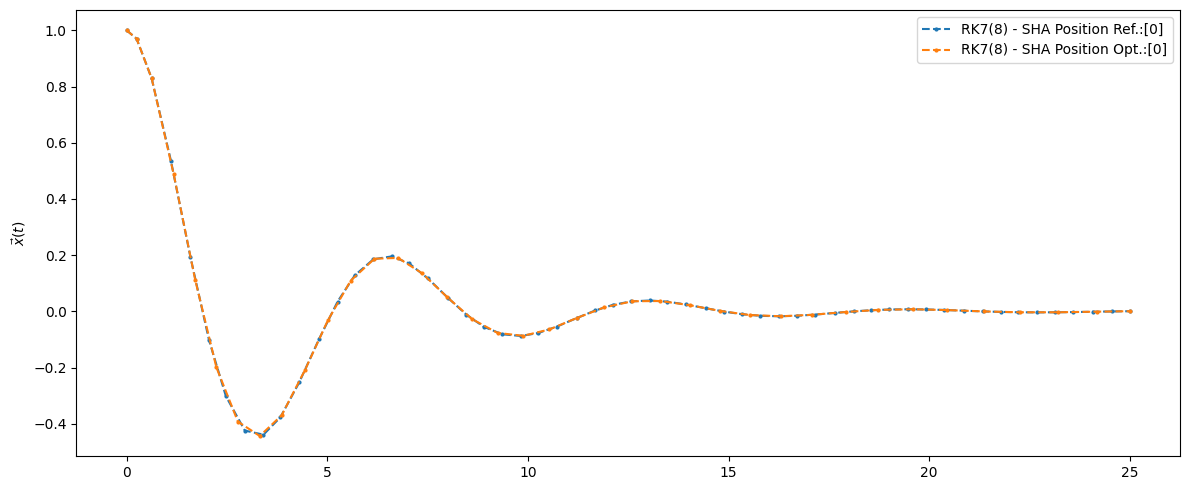

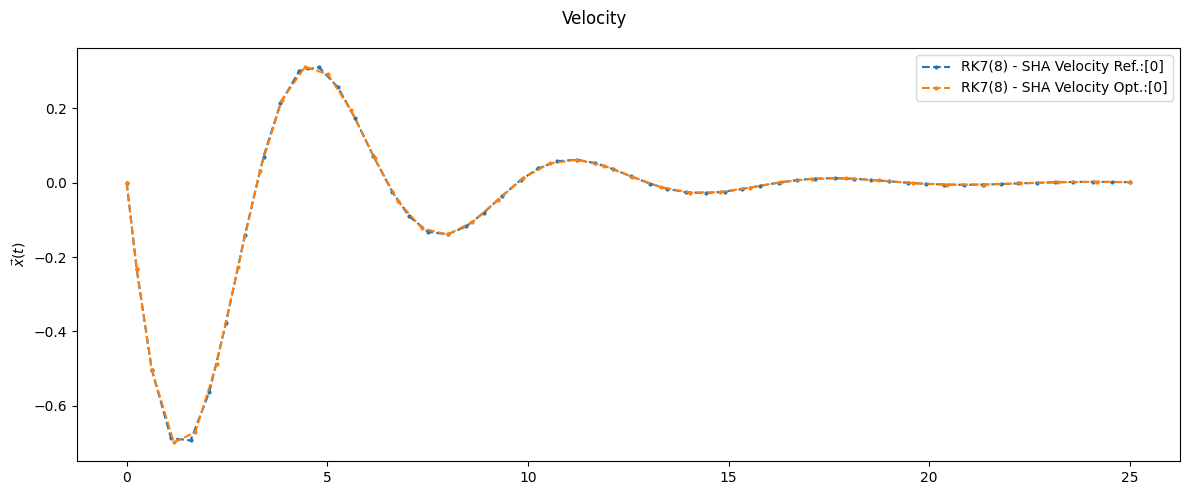

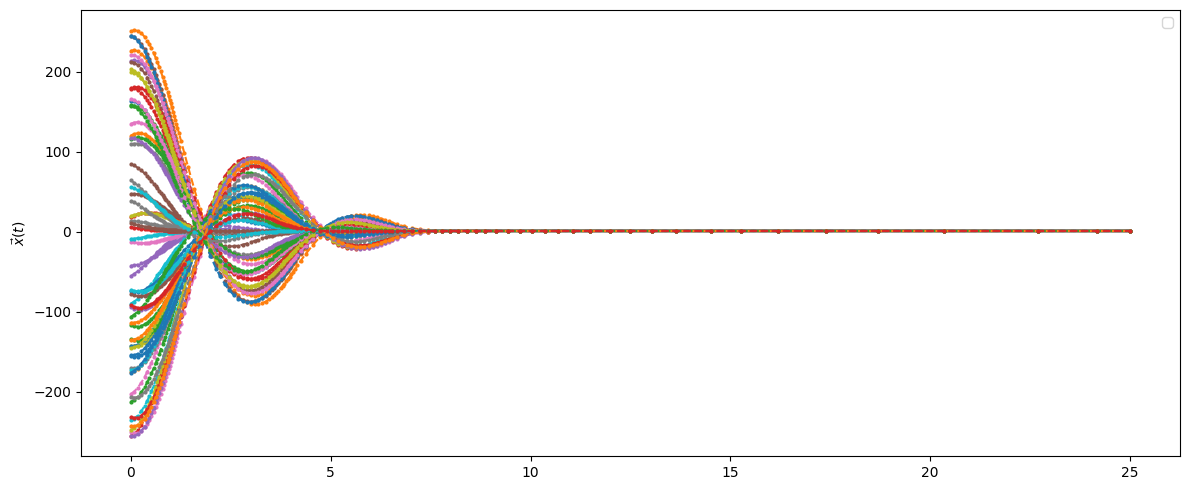

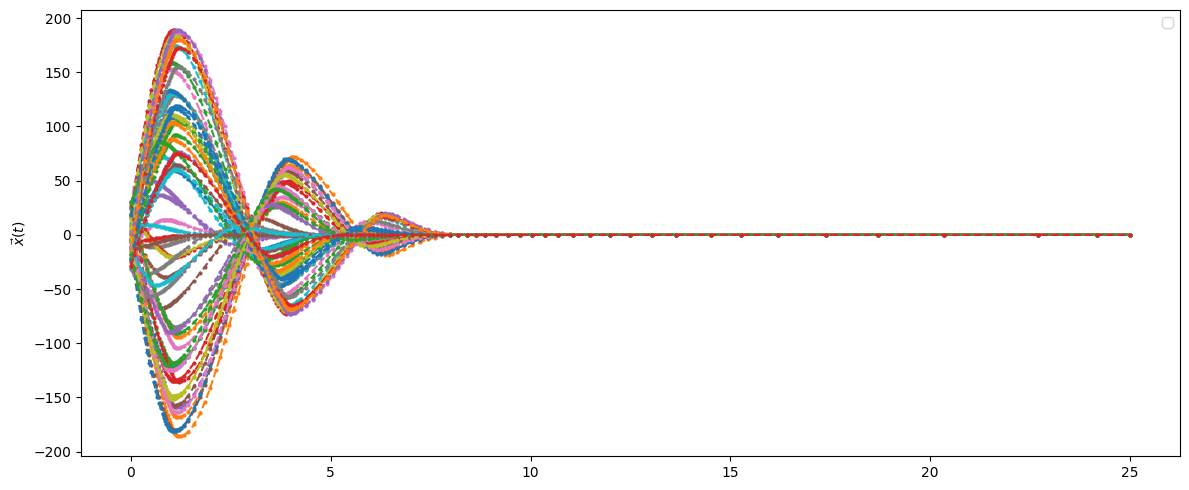

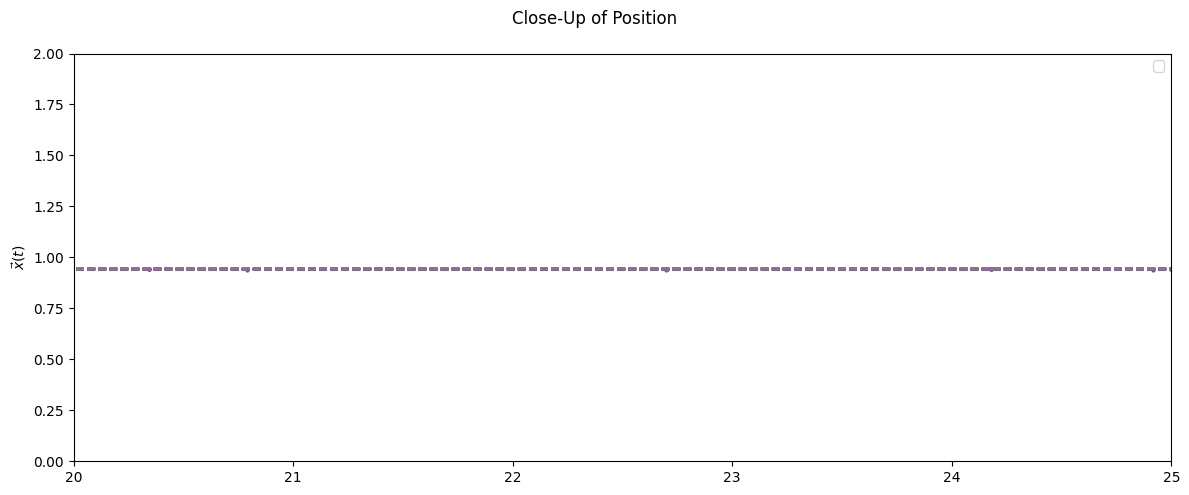

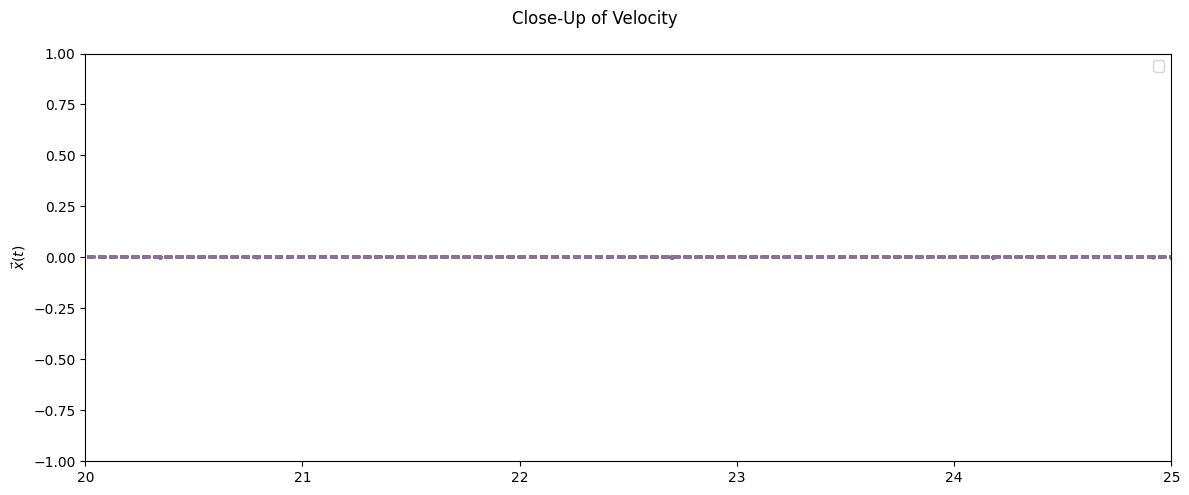

In [18]:
_, _, learned_dynamics_states, learned_dynamics_times, _ = current_integrator.apply(learned_dynamics_rhs, initial_state, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol})

ig_ref_position, axes_ref_position = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK7(8) - SHA Position Ref.")
fig_ref_velocity, axes_ref_velocity = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK7(8) - SHA Velocity Ref.")

_ = neuralode.plot.trajectory.plot_trajectory([(i[...,0], j) for i, j in zip(learned_dynamics_states, learned_dynamics_times)], axes=axes_ref_position, method_label="RK7(8) - SHA Position Opt.")
fig_ref_position.suptitle("Position")
_ = neuralode.plot.trajectory.plot_trajectory([(i[...,1], j) for i, j in zip(learned_dynamics_states, learned_dynamics_times)], axes=axes_ref_velocity, method_label="RK7(8) - SHA Velocity Opt.")
fig_ref_velocity.suptitle("Velocity")

_, _, integrated_test_states, integrated_test_times, _ = current_integrator.apply(controlled_dynamics_rhs, test_state_dataset, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol})

print("Training results on test data:")
print(f"\tMean position at t={final_time.item():.2f}s: {integrated_test_states[-1, ..., 0].mean().item():.4e} ± {integrated_test_states[-1, ..., 0].std().item():.4e}")
print(f"\tMean position error at t={final_time.item():.2f}s: {(target_state - integrated_test_states)[-1, ..., 0].mean().item():.4e} ± {(target_state - integrated_test_states)[-1, ..., 0].std().item():.4e}")
print()
print(f"\tMean velocity at t={final_time.item():.2f}s: {integrated_test_states[-1, ..., 1].mean().item():.4e} ± {integrated_test_states[-1, ..., 1].std().item():.4e}")
print(f"\tMean velocity error at t={final_time.item():.2f}s: {(target_state - integrated_test_states)[-1, ..., 1].mean().item():.4e} ± {(target_state - integrated_test_states)[-1, ..., 1].std().item():.4e}")

neuralode.plot.trajectory.plot_trajectory([(i[...,0], j) for i, j in zip(integrated_test_states, integrated_test_times)], method_label=None)
neuralode.plot.trajectory.plot_trajectory([(i[...,1], j) for i, j in zip(integrated_test_states, integrated_test_times)], method_label=None)

fig_ref_position_closeup, axes_ref_position_closeup = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(dha_states_optimised, dha_times_optimised)], method_label=None)
fig_ref_velocity_closeup, axes_ref_velocity_closeup = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(dha_states_optimised, dha_times_optimised)], method_label=None)

_ = neuralode.plot.trajectory.plot_trajectory([(i[...,0], j) for i, j in zip(integrated_test_states, integrated_test_times)], axes=axes_ref_position_closeup, method_label=None)
fig_ref_position_closeup.suptitle("Close-Up of Position")
axes_ref_position_closeup[0].set_xlim(final_time.item() - 5.0, final_time.item())
axes_ref_position_closeup[0].set_ylim(target_state[0].item() - 1.0, target_state[0].item() + 1.0)

_ = neuralode.plot.trajectory.plot_trajectory([(i[...,1], j) for i, j in zip(integrated_test_states, integrated_test_times)], axes=axes_ref_velocity_closeup, method_label=None)
fig_ref_velocity_closeup.suptitle("Close-Up of Velocity")
axes_ref_velocity_closeup[0].set_xlim(final_time.item() - 5.0, final_time.item())
axes_ref_velocity_closeup[0].set_ylim(target_state[1].item() - 1.0, target_state[1].item() + 1.0)